(8, 10000)


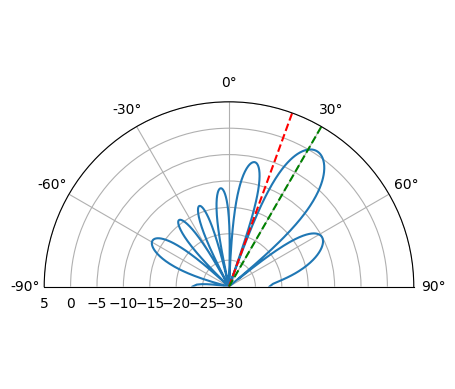

In [1]:
import numpy as np
import matplotlib.pyplot as plt

d = 0.5 # half wavelength spacing
Nr = 8 # number of elements in the array

theta_jammer = np.deg2rad(20) # direction of arrival (feel free to change this, it's arbitrary)
sample_rate = 1e6
N = 10000 # number of samples to simulate

# Create a tone to act as the jamming signal
t = np.arange(N)/sample_rate # time vector
f_tone = 0.02e6
tx = np.exp(2j * np.pi * f_tone * t)
s = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_jammer))
s = s.reshape(-1,1) # make s a column vector (3x1)
tx = tx.reshape(1,-1) # make tx a row vector (1x10000)

# Simulate the received signal X through a matrix multiply
X = s @ tx 
print(X.shape) # 3x10000.  X is now going to be a 2D array, 1D is time and 1D is the spatial dimension
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
X = X + 0.5*n # X and n are both 3x10000

theta_soi = np.deg2rad(30) # direction we want to point towards (signal of interest)

# theta is the direction of interest, in radians, and X is our received signal
s = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_soi)) # steering vector in the desired direction theta
s = s.reshape(-1,1) # make into a column vector (size 3x1)
R = (X @ X.conj().T)/X.shape[1] # Calc covariance matrix. gives a Nr x Nr covariance matrix of the samples
Rinv = np.linalg.pinv(R) # 3x3. pseudo-inverse tends to work better/faster than a true inverse
w = (Rinv @ s)/(s.conj().T @ Rinv @ s) # MVDR/Capon equation! numerator is 3x3 * 3x1, denominator is 1x3 * 3x3 * 3x1, resulting in a 3x1 weights vector

w = w.squeeze() # remove the extra dimension (3x1 to 3)

# Visualize the beam pattern (don't worry as much about this part)
N_fft = 1024
w = np.conj(w) # or else our answer will be negative/inverted
w_padded = np.concatenate((w, np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # Map the FFT bins to angles in radians
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_bins, w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
ax.plot([theta_jammer, theta_jammer], [-30, 5], 'r--')
ax.plot([theta_soi, theta_soi], [-30, 5], 'g--')
ax.set_theta_zero_location('N') # type: ignore # make 0 degrees point up
ax.set_theta_direction(-1) # type: ignore # increase clockwise
ax.set_thetamin(-90) # type: ignore # only show top half
ax.set_thetamax(90) # type: ignore
ax.set_ylim((-30, 5)) # because there's no noise, only go down 30 dB
plt.show()